# ___

# [ Machine Learning in Geosciences ]

### | Topic: **GeoAI: Land Cover classification with Sentinel-2 and ST_LUCAS** 

### | Thematic focus: Land Cover

.....................................................................................................................

Author: *Lukas Brodsky* *lukas.brodsky@natur.cuni.cz* 

---

# 1. Problem definition 

### 1.1 Background

Land cover classification is a crucial task in remote sensing and environmental monitoring, providing valuable insights for urban planning, agriculture, forestry, and climate studies. Sentinel-2, a satellite mission by the European Space Agency (ESA), offers high-resolution multispectral imagery suitable for land cover classification. The ST_LUCAS (LUCAS – Land Use/Cover Area frame Survey) dataset provides ground truth reference data, making it a valuable resource for training and validating machine learning models.

By leveraging Sentinel-2 imagery and ST_LUCAS reference data, machine learning models can efficiently classify land cover types, improving accuracy and automation in large-scale environmental analysis. The integration of these datasets enables the development of robust classification models that can generalize across different landscapes.


### 1.2. Objective: 

The primary objective of this task is to develop and evaluate a machine learning model for land cover classification using Sentinel-2 satellite imagery and ST_LUCAS reference data. The key goals include:

* Data Preprocessing – Extract and preprocess Sentinel-2 spectral bands, align them with ST_LUCAS reference points, and apply necessary corrections.
* Sample ST_LUCAS data based on spatial-kfold samling and apply spatial cross-validation. 
* Feature Engineering – Select relevant spectral indices (e.g., NDVI, NDWI) and additional features to enhance classification performance.
* Model Training & Optimization – Train a machine learning model (e.g., Random Forest) using labeled data from ST_LUCAS and optimize its parameters.
* Validation & Accuracy Assessment – Evaluate the model performance.
* Compare model results when using random sampling and spatial sampling. 

### 1.3 Expected results 

* Land Cover Classification Map – A high-resolution map with classified land cover types, generated from Sentinel-2 data, and validated using ST_LUCAS references.
* Performance Metrics – Random and spatial sampling classification accuracy metrics using F1-score.
* Feature Importance Analysis – Identification of the most influential Sentinel-2 bands and spectral indices contributing to classification accuracy.

In [5]:
# !pip install spatial-kfold

In [4]:
import os 
import glob
import rasterio
import rasterio.features
from rasterio.enums import MergeAlg
from rasterio.plot import show
from rasterio.features import rasterize
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import numpy as np
from shapely.geometry import box
import geopandas as gpd 
# from st_lucas import LucasRequest
# from st_lucas import LucasIO

# Random Cross-Validation using KFold
from sklearn.model_selection import KFold
# Stratified Cross-Validation using StratifiedKFold
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib as mpl

from spatialkfold.blocks import spatial_blocks 
from spatialkfold.datasets import load_ames
from spatialkfold.clusters import spatial_kfold_clusters 
from spatialkfold.plotting import spatial_kfold_plot
from spatialkfold.stats import spatial_kfold_stats

# 2. Data Collection & Preparation
EPSG: 32633 

In [ ]:
# Google Drive to download data: 
# https://drive.google.com/drive/folders/1OraTxkjJy597P-vWyFZWVIwDvJ0iX_-u?usp=sharing 

In [6]:
# CONFIG
DIR_PATH = './data'
S2_BANDS_DIR = os.path.join(DIR_PATH, 'S2A_MSIL2A_20180506T100031_N0207_R122_T33UVQ_20180506T105839.SAFE/GRANULE/*/IMG_DATA/R10m')
LUCAS_SHP = os.path.join(DIR_PATH, 'cz_lucas_region_grow.shp') 
OUTPUT_TIF = os.path.join(DIR_PATH, 'land_cover_cz_33UVQ_2018.tif') 
LABEL_FIELD = 'lc' 
EPSG_CODE = 32633
N_SPLITS = 5
SCALE_FACTOR = 10000

In [7]:
# Load LUCAS polygons
lucas_gdf = gpd.read_file(LUCAS_SHP)
lucas_gdf = lucas_gdf.to_crs(epsg=EPSG_CODE)
print("Number of polygons:", len(lucas_gdf))
print("Columns:", lucas_gdf.columns)

Number of polygons: 5348
Columns: Index(['point_id', 'tile_id', 'lc1_h', 'lc1_name', 'osm_codes', 'osm_names',
       'osm_lc', 'multiclass', 'geom_type', 'obs_type', 'obs_dist', 'gps_prec',
       'gprec_src', 'lc', 'similarity', 'pt_update', 'rect', 'length', 'width',
       'area', 'ratio', 'shp_gen', 'geometry'],
      dtype='object')


In [8]:
# Load Sentinel-2 bands
band_paths = {
    'B02': glob.glob(os.path.join(S2_BANDS_DIR, '*B02_10m.jp2'))[0],
    'B03': glob.glob(os.path.join(S2_BANDS_DIR, '*B03_10m.jp2'))[0],
    'B04': glob.glob(os.path.join(S2_BANDS_DIR, '*B04_10m.jp2'))[0],
    'B08': glob.glob(os.path.join(S2_BANDS_DIR, '*B08_10m.jp2'))[0]
}

In [9]:
# Read each band and stack them
band_arrays = []
for name, path in band_paths.items():
    with rasterio.open(path) as src:
        band = src.read(1)  # Read the first band (single layer)
        band_arrays.append(band)

In [10]:
# Stack the bands into a 3D array: (height, width, num_bands)
stacked_img = np.stack(band_arrays, axis=-1)
print("stacked shape:", stacked_img.shape)  # Should be (height, width, num_bands)

stacked shape: (10980, 10980, 4)


### Feature engineering 

In [11]:
# Extract individual bands for index computation
B03, B04, B08 = band_arrays[1], band_arrays[2], band_arrays[3]

In [12]:
# NDVI = (NIR - Red) / (NIR + Red)
ndvi = (B08 - B04) / (B08 + B04 + 1e-6) * SCALE_FACTOR

In [13]:
# NDWI = (Green - NIR) / (Green + NIR)
ndwi = (B03 - B08) / (B03 + B08 + 1e-6) * SCALE_FACTOR

In [14]:
# Add indices to the stack
stacked_img = np.concatenate([stacked_img, ndvi[..., np.newaxis], ndwi[..., np.newaxis]], axis=-1)

In [15]:
stacked_img.shape

(10980, 10980, 6)

### Data harmonization

In [16]:
# Get raster bounds and load raster base layer for visualization
with rasterio.open(band_paths['B02']) as src:
    raster_bounds = src.bounds
    raster_image = src.read(1)
    raster_shape = src.shape
    raster_transform = src.transform
    extent = [raster_bounds.left, raster_bounds.right, raster_bounds.bottom, raster_bounds.top]

In [17]:
# Convert bounds to shapely box for filtering
raster_bbox = box(*raster_bounds)

In [18]:
# Filter only LUCAS polygons intersecting the raster
lucas_subset = lucas_gdf[lucas_gdf.intersects(raster_bbox)]

In [19]:
lucas_subset.shape

(719, 23)

In [20]:
719 / N_SPLITS

143.8

In [21]:
# Check unique values to confirm it's correct
print("LUCAS land cover classes:", lucas_gdf[LABEL_FIELD].unique())

LUCAS land cover classes: [ 4  8  2  1  7 10  9  3 12]


In [22]:
# Prepare shapes for rasterization
shapes = ((geom, int(val)) for geom, val in zip(lucas_gdf.geometry, lucas_gdf[LABEL_FIELD]))
# Rasterize with original raster shape and transform
rasterized = rasterize(
    shapes=shapes,
    out_shape=raster_shape,
    transform=raster_transform,
    fill=0,  # 0 = NoData
    dtype='uint8'
)

In [24]:
rasterized.shape

(10980, 10980)

In [25]:
# Flatten stacked_img to (num_pixels, num_features)
valid_mask = (rasterized > 0) # & (group_raster > 0)
stacked_flat = stacked_img.reshape(-1, stacked_img.shape[-1])
valid_mask_flat = valid_mask.flatten()
rasterized_flat = rasterized.flatten()

In [26]:
# ML-ready arrays
print("stacked shape:", stacked_img.shape)
print("stacked_flat shape:", stacked_flat.shape)
print("valid_mask_flat shape:", valid_mask_flat.shape)

stacked shape: (10980, 10980, 6)
stacked_flat shape: (120560400, 6)
valid_mask_flat shape: (120560400,)


In [27]:
X = stacked_flat[valid_mask_flat]  # Features based on valid mask
y = rasterized_flat[valid_mask_flat]  # Corresponding labels

In [28]:
X.shape

(53845, 6)

In [29]:
y.shape

(53845,)

# 3. Exploratory Data Analysis (EDA)


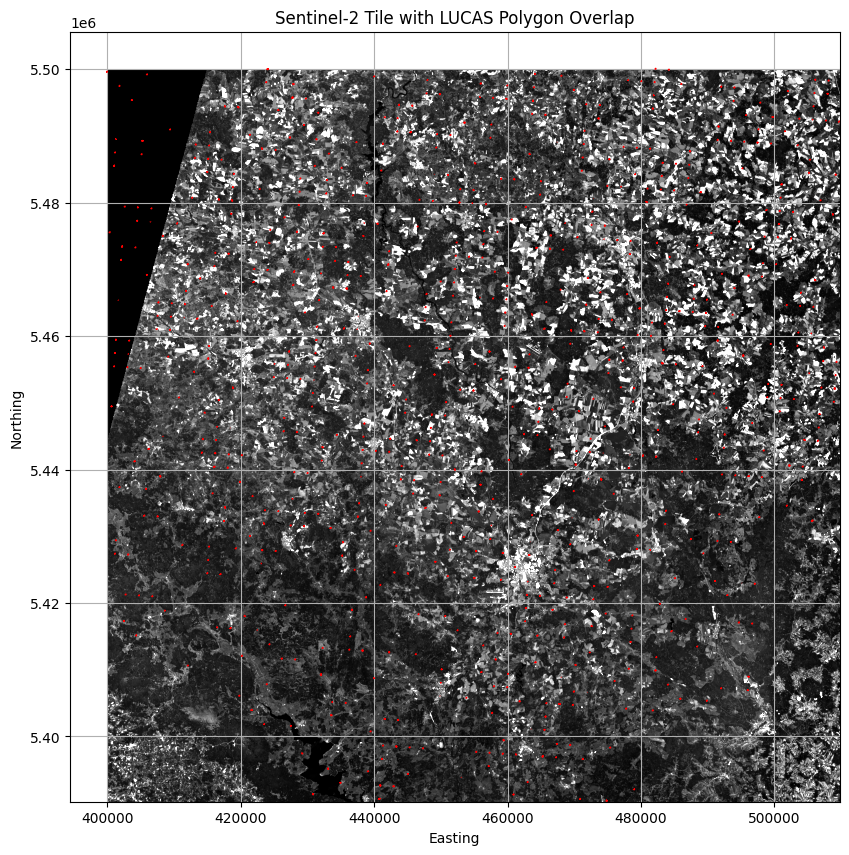

In [30]:
# View image and samples
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(raster_image, cmap='gray', vmin=100, vmax=1000, extent=extent, origin='upper')
lucas_subset.boundary.plot(ax=ax, edgecolor='red', linewidth=1)
ax.set_title('Sentinel-2 Tile with LUCAS Polygon Overlap')
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
plt.grid(True)
plt.show()

In [ ]:
# Nomenclature coding 
nomenclature ={
        1: "artificial land ",
        2: "agriculture",
        3: "woodland",
        4: "shrubland",
        5: "grassland",
        6: "bareland", 
        7: "water", 
        8: "wetlands"
}

In [ ]:
colours = {
    1: (255./255,   0./255,   0./255, 0.5),   # red 
    2: (255./255, 255./255,   0./255, 0.5),   # yeallow
    3: ( 51./255, 160./255,  44./255, 1  ),   # dark green
    4: (223./255, 223./255, 138./255, 1  ),   # light greyish green
    5: (  0./255, 223./255,   0./255, 0.5),   # green
    6: (211./255, 211./255, 211./255, 1  ),   # grey
    7: (  0./255,   0./255, 255./255, 0.5),   # blue
    8: (238./255, 130./255, 238./255, 0.5)    # violet
}


In [ ]:
# Feature scatter plot
# plt.scatter(s2array_flat[2, :], s2array_flat[4, :], s=1, alpha=0.7, 
#             c=lucas_array_flat, cmap=cmap)
# plt.xlabel('RED')
# plt.ylabel('NIR')
# plt.colorbar()

# 4. Model Selection & Training

# 5. Model fine-tuning 
* hyperparameters fine-tuning 
* random and spatial sampling comparison  
* models evaluation

### Random sampling


In [31]:
### Training and validation
def evaluate_model(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    return f1_train, f1_test

In [32]:
# Setup for random sampling
scores_random = []
kf_random = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)


In [33]:
# Train the model using RandomForestClassifier and perform cross-validation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30]
}

In [34]:
# training 
for train_idx, test_idx in kf_random.split(X, y):
    # break
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    # Grid search with 3-fold CV
    rf_base = RandomForestClassifier(n_jobs=os.cpu_count()-2, random_state=42)
    grid_search = GridSearchCV(rf_base, param_grid, cv=3, scoring='f1_weighted', n_jobs=os.cpu_count()-2, verbose=1)
    grid_search.fit(X_train, y_train)

    # Best model
    clf = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)
    f1_train, f1_test = evaluate_model(clf, X[train_idx], y[train_idx], X[test_idx], y[test_idx])
    scores_random.append((f1_train, f1_test))


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}


In [35]:
# Output Random CV Results
print(f"Random Cross-Validation F1-scores: {scores_random}")


Random Cross-Validation F1-scores: [(0.9582974891458693, 0.8581005528171275), (0.8560480860819888, 0.8404228156690177), (0.9588139110657672, 0.8540502028965078), (0.8567732379020135, 0.8377491850089039), (0.8563617360360606, 0.8432186343845448)]


### Spatial cross-validation

In [36]:
# Create blocks using centroid-based selection
blocks = spatial_blocks(gdf=lucas_subset, width=10000, height=10000, 
                        method='random', nfolds=N_SPLITS, 
                        random_state=42)

c:\Program Files\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Program Files\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Program Files\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Program Files\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Program Files\Python3

In [37]:
# Function to rasterize blocks for a given fold
def rasterize_fold(selected_blocks, fold_value, raster_shape, raster_transform):
    
    # replace to union_all()
    selected_geom = selected_blocks.unary_union
    selected_lucas = lucas_subset[lucas_subset.intersects(selected_geom)]
    
    # Prepare shapes for rasterization
    shapes = ((geom, int(val)) for geom, val in zip(selected_lucas.geometry, selected_lucas[LABEL_FIELD]))
    
    rasterized_fold = rasterize(
        shapes=shapes,
        out_shape=raster_shape,
        transform=raster_transform,
        fill=0,  # 0 = NoData
        dtype='uint8'
    )
    return rasterized_fold

In [46]:
def spatial_cross_validation(blocks, raster_shape, raster_transform, n_splits):
    scores = []
    for fold_value in range(1, n_splits + 1):
        print(f"Processing fold {fold_value}...")
        train_blocks = blocks[blocks['folds'] != fold_value]
        test_blocks = blocks[blocks['folds'] == fold_value]

        # Training pixels 
        train_raster = rasterize_fold(train_blocks, fold_value, raster_shape, raster_transform)
        test_raster = rasterize_fold(test_blocks, fold_value, raster_shape, raster_transform)

        # Get training pixels from Sentinel2 
        valid_mask_train = (train_raster > 0) 
        rasterized_train_flat = train_raster.flatten()
        valid_mask_train_flat = valid_mask_train.flatten()
        X_train = stacked_flat[valid_mask_train_flat]  
        y_train = rasterized_train_flat[valid_mask_train_flat]  

        # Get test pixels 
        valid_mask_test = (test_raster > 0) 
        rasterized_test_flat = test_raster.flatten()
        valid_mask_test_flat = valid_mask_test.flatten()
        X_test = stacked_flat[valid_mask_test_flat]  
        y_test = rasterized_test_flat[valid_mask_test_flat]  
        
        # Grid search with 3-fold CV
        rf_base = RandomForestClassifier(n_jobs=os.cpu_count()-2, random_state=42)
        grid_search = GridSearchCV(rf_base, param_grid, cv=3, scoring='f1_weighted', n_jobs=os.cpu_count()-2, verbose=1)
        grid_search.fit(X_train, y_train)
    
        # Best model
        clf = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        f1_train, f1_test = evaluate_model(clf, X_train, y_train, X_test, y_test)
        scores.append((f1_train, f1_test))

        # break

    return scores

In [47]:
# Run spatial cross-validation
scores_spatial = spatial_cross_validation(blocks, raster_shape, raster_transform, N_SPLITS)


Processing fold 1...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Processing fold 2...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Processing fold 3...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Processing fold 4...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Processing fold 5...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'max_depth': 10, 'n_estimators': 100}


In [48]:
# Output results
print(f"Spatial Cross-Validation F1-scores: {scores_spatial}")

Spatial Cross-Validation F1-scores: [(0.9609173243472939, 0.8308609466730741), (0.858038329266272, 0.8168940336216447), (0.9708425664521748, 0.7560455447209989), (0.8563260321888401, 0.8146328147220765), (0.8539285356555852, 0.8416152579517808)]


In [49]:
# Combine scores and calculate means
cv_results = {
    'Random': scores_random,
    'Spatial': scores_spatial, 
}   

In [52]:
# Print average scores 
for method, scores in cv_results.items():
    train_avg = np.median([s[0] for s in scores])
    test_avg = np.median([s[1] for s in scores])
    print(f"{method} CV → Median Train F1: {train_avg:.3f}, Median Test F1: {test_avg:.3f}")


Random CV → Median Train F1: 0.857, Median Test F1: 0.843
Spatial CV → Median Train F1: 0.858, Median Test F1: 0.817


In [ ]:
# cv_results

# 6. Results presentation and interpretation 

In [53]:
### Explanations
import shap

In [62]:
X_train.shape

(43076, 6)

In [64]:
y_train.shape

(43076,)

In [63]:
from sklearn.ensemble import RandomForestRegressor

rforest = RandomForestRegressor(n_estimators=1000, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
# print_accuracy(rforest.predict)

RandomForestRegressor(n_estimators=1000, random_state=0)

In [65]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)


In [69]:
X_test.shape

(10769, 6)

In [68]:
shap_values.shape

(10769, 6, 8)

In [72]:
# shap.summary_plot(shap_values, X_test)

In [ ]:
### Predictions - takes long time!!! 

In [ ]:
# Predict the entire image using the final model
predictions = clf.predict(stacked_flat)

In [ ]:
predictions.shape

In [ ]:
stacked_img.shape

In [ ]:
predictions_raster = predictions.reshape(stacked_img.shape[-1])

In [ ]:
# Save the result to a GeoTIFF
with rasterio.open(band_paths['B02']) as src:
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

    with rasterio.open(OUTPUT_TIF, 'w', **profile) as dst:
        dst.write(predictions_raster, 1)

print("Land cover map saved as:", OUTPUT_TIF)

In [ ]:
# Plot
plt.figure(figsize=(10, 10))
im = plt.imshow(predictions_raster, cmap=colormap, interpolation='none')
cbar = plt.colorbar(im, ticks=unique_labels)
cbar.set_label('Land Cover Class')
plt.title('Land Cover Classification Map')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.grid(True)
plt.show()

In [ ]:
# Resutls interpretation